#### Import Statements

In [ ]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR100
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score

import numpy as np
import tqdm
import matplotlib.pyplot as plt 

##### Parameters Function

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
# Download data

batch_size = 32

transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

training_data = torchvision.datasets.CIFAR100(root='./data', 
                                         train=True,
                                         download=True, 
                                         transform=transform)
train_dataloader = torch.utils.data.DataLoader(training_data, 
                                               batch_size=batch_size, 
                                               shuffle=True,
                                               num_workers=2)
test_data = torchvision.datasets.CIFAR100(root='./data',
                                          train=False,
                                          download=True,
                                          transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=2)

# Create data loader
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Load one batch of training data
for data in train_dataloader:
  break

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class_names = ('beaver', 'dolphin', 'otter', 'seal', 'whale',
               'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
               'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
               'bottles', 'bowls', 'cans', 'cups', 'plates',
               'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
               'clock', 'computer keyboard', 'lamp', 'telephone', 'television',
               'bed', 'chair', 'couch', 'table', 'wardrobe',
               'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
               'bear', 'leopard', 'lion', 'tiger', 'wolf',
               'bridge', 'castle', 'house', 'road', 'skyscraper',
               'cloud', 'forest', 'mountain', 'plain', 'sea',
               'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
               'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
               'crab', 'lobster', 'snail', 'spider', 'worm',
               'baby', 'boy', 'girl', 'man', 'woman',
               'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
               'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
               'maple', 'oak', 'palm', 'pine', 'willow',
               'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
               'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor')

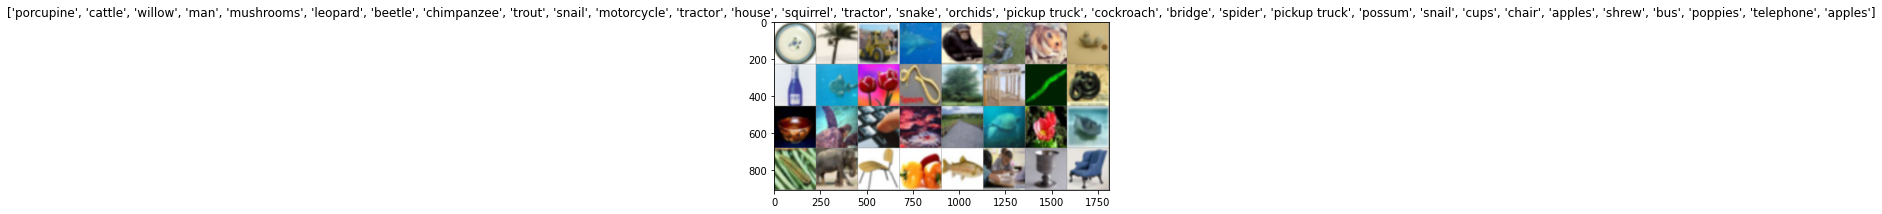

In [ ]:
def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # Pause so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### AlexNet Model

In [ ]:
class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()

    # First Convolution
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(11,11), stride=(4,4), padding=(2,2)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),

        nn.Conv2d(in_channels=64, out_channels=192, kernel_size=(5,5), stride=(1,1), padding=(2,2)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),

        nn.Conv2d(in_channels=192, out_channels=384, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
       )
    
    self.flatten = nn.Flatten()

    self.fc1 = nn.Sequential(
        nn.Dropout(0.5, inplace=False),
        nn.Linear(9216, 4096, bias=True),
        nn.ReLU(inplace=True) 
    )
    
    self.fc2 = nn.Sequential(
        nn.Dropout(0.5, inplace=False),
        nn.Linear(4096, 4096, bias=True),
        nn.ReLU(inplace=True)        
    )

    self.fc3 = nn.Linear(4096,100, bias=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    logits = self.fc3(x)
    return logits


##### Train Function

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
  model.train() # set model to train model
  for step, (x, y) in enumerate(dataloader): 
    # send data to GPU or CPU
    x = x.to(device)
    y = y.to(device)
    
    # feed the data to the model
    pred = model(x)
    
    # compute the loss
    loss = loss_fn(pred, y)
    
    # backpropagation (update the parameters)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 200 == 0: 
      loss  = loss.item()
      print('Current Step: %d, loss:%.4f' %(step, loss))
      


##### Test Function

In [ ]:
def test(dataloader, model, loss_fn, device):
  num_batch = len(dataloader)

  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)
      pred = model(x)
      loss = loss_fn(pred, y)
      test_loss += loss.item()
      
      y_hat = pred.argmax(1)
      correct_batch = (y_hat == y).type(torch.float).sum().item()
      correct += correct_batch
  test_loss /= num_batch
  accuracy = correct / (num_batch * batch_size)
  f1 = f1_score(pred, y, task="multiclass", num_classes=100).to(device)
  print("Test Accuracy:%.4f" %accuracy)
  print("F1 Score:%4f" %f1)

  

#### Train the Model

In [ ]:
# Get CPU or GPU for the training
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [ ]:
# Create the model
model = AlexNet().to(device)
print("---------------\nTraining the AlexNet model")
print("Total number of trainable parameters:%d \n------------" %count_parameters(model))
print(model)

# Optimizing the model parameter
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)

# Train model in epochs
epochs = 25
for t in tqdm.tqdm(range(epochs)):
  print('Epoch %d \n----------------' %t)
  train(train_dataloader, model, loss_fn, optimizer, device)
  test(test_dataloader, model, loss_fn, device)
print("Done!")


#### Predict Test Set

In [ ]:
nb_classes = 100

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    test_running_corrects = 0.0
    test_total = 0.0
    model.eval()
    for i, (test_inputs, test_labels) in enumerate(test_dataloader, 0):
        test_inputs, test_labels = test_inputs.cuda(), test_labels.cuda()

        test_outputs = model(test_inputs)
        _, test_outputs = torch.max(test_outputs, 1)
        
        test_total += test_labels.size(0)
        test_running_corrects += (test_outputs == test_labels).sum().item()
        
        for t, p in zip(test_labels.view(-1), test_outputs.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

precision = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
recall = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])

f1_score = 2 * precision * recall / (precision + recall)
print(f'F1 Score: {f1_score: .3f}')

#### F1 Score

In [ ]:
precision = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[1][0])
recall = confusion_matrix[0][0] / (confusion_matrix[0][0] + confusion_matrix[0][1])

f1_score = 2 * precision * recall / (precision + recall)
print(f'F1 Score: {f1_score: .3f}')